In [1]:
import pandas_gbq
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [20]:
q='''
SELECT 
IFNULL(value.incentives.voucher_total_eur,0) as is_voucher_incentive_value, 
IFNULL(value.incentives.discount_dh_eur,0)+IFNULL(value.incentives.discount_other_eur,0) is_discount_incentive_value,
IFNULL(value.incentives.joker_customer_discount_eur,0) is_joker_incentive_value,
IFNULL(value.incentives.voucher_total_eur,0)+IFNULL(value.incentives.discount_dh_eur,0)+IFNULL(value.incentives.discount_other_eur,0)
+IFNULL(value.incentives.joker_customer_discount_eur,0) as total_incentive_value,
value.order.gmv_eur as basket_value, 
is_discount, 
is_voucher, 
is_joker,
is_free_delivery 
FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` 
WHERE is_successful = true and global_entity_id="FO_NO" and date(partition_date_local) = "2023-12-12"
'''

In [21]:
df = pandas_gbq.read_gbq(q)

Downloading: 100%|██████████|


In [22]:
df[df['is_joker']==True]
#print(len(df[df['is_discount']==True]))

,is_voucher_incentive_value,is_discount_incentive_value,is_joker_incentive_value,total_incentive_value,basket_value,is_discount,is_voucher,is_joker,is_free_delivery
23,0E-9,0E-9,3.800000000,3.800000000,13.010000000,True,False,True,True
57,0E-9,0E-9,3.800000000,3.800000000,13.690000000,True,False,True,True
74,0E-9,0E-9,3.800000000,3.800000000,13.770000000,True,False,True,True
93,0E-9,0E-9,8.450000000,8.450000000,28.560000000,True,False,True,True
152,0E-9,0E-9,3.800000000,3.800000000,14.280000000,True,False,True,True
...,...,...,...,...,...,...,...,...,...
14707,0E-9,0E-9,8.450000000,8.450000000,62.520000000,True,False,True,False
14719,0E-9,0E-9,8.450000000,8.450000000,58.630000000,True,False,True,False
14783,0E-9,0E-9,8.450000000,8.450000000,47.820000000,True,False,True,False
14819,0E-9,0E-9,8.450000000,8.450000000,52.470000000,True,False,True,False


In [23]:
def plot_hist(df, subset):
    df_sub = df[df[subset]==True]
    print("Share: %", round(len(df_sub)*100/len(df), 2))
    fig, ax = plt.subplots(figsize = (4,4))
    ax.hist(df_sub['total_incentive_value'], alpha=0.5, label='total_incentive_value')
    if subset!="is_free_delivery":
        ax.hist(df_sub[subset+'_incentive_value'], alpha=0.5, label='basket_value_incentive_specific')
    ax.hist(df_sub['basket_value'], alpha=0.5, label='basket_value')
    ax.legend(loc='upper right')
    plt.show()

def plot_all(df):
    for col in df.columns:
        if "value" not in col and "is_" in col and 'incentive_value' not in col:
            print(col)
            plot_hist(df, col)

is_discount
Share: % 22.97


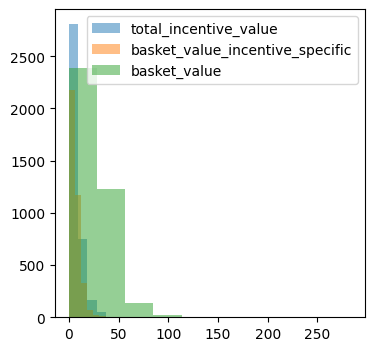

is_voucher
Share: % 10.5


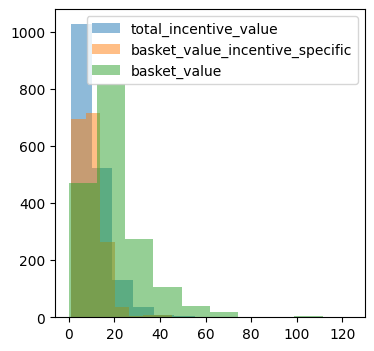

is_joker
Share: % 3.4


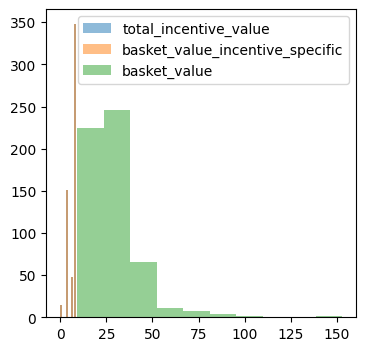

is_free_delivery
Share: % 28.78


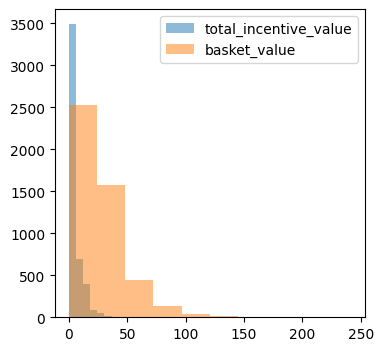

In [24]:
plot_all(df) #EUR

In [ ]:
df.columns

### Columns description:
#### Incentives
- **is_discount**: True if some other discount was given (**and used?**) to the customer (other than voucher and joker), e.g. Meal deal / Happy hour / Free drink / Pizza Montag / Free Delivery etc.	
- **is_voucher**: True if a voucher code was used, when the customer types in a code during the order process to receive a price reduction.	
- **is_free_delivery**: True if there was no delivery fee for the order.
- **is_joker**: True if the joker feature was used in the order process.
- **gmv_eur**: Gross Merchandise Value (GMV) is a metric that measures your total value of sales over a certain period of time. In this case we are calculating for each order the total amount Paid compulsory by Customer (also called MPR after DH Subsidy). Note that for top-level reporting this is calculated on Successful Orders, but not necessarily on Commissionable Orders. Includes VAT, all fees and incentives. Excludes Rider tip. Amount the customer paid (after vouchers and discounts, including delivery fee, allowance amount and **excluding tips**) in Euro.

For the discounts:
- **is_voucher_incentive_value**: we take the value.incentives.voucher_total_eur value which includes both DH vouchers and non
- **is_discount_incentive_value**: we sum discount_dh_eur and discount_other_eur because discount_total_eur also contains joker - also summing all the appropriate columns the result wil still differ from the "total" column due to rounding errors
- **is_joker_incentive_value**: the value is not null only if the joker feature was used in the order process (joker is a customized incentive, time limited)
- delivery free has no incentive value

Potentially interesting columns:
is_acquisition, is_corporate, is_qcommerce, value.incentives.wallet_total_eur

A way to differentiate dh vs vendor voucher value is to look at the respective voucher amount (the column contains a voucher amount breakdown).

To calculate the incentive value:
vouchers.amount_eur field is similar to value.incentives.voucher_total_eur (field I actually used), but in amount_eur the voucher value is divided against each voucher code/ campaign name.

Commission data info comes a month later, however January did not seem to have data for the day - but we are not interested in commission data.